# Gravity lense classification using previous lensiformer structure with physics-informed layers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
import numpy as np
from torch import nn
from torch import Tensor
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from typing import Tuple, Union, List
from sklearn.metrics import accuracy_score
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch
from torch import nn, einsum
import torch.nn.functional as F
from torchvision.transforms import functional as VF
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import scienceplots
from tqdm import tqdm
plt.style.use(['science','ieee','no-latex'])

/home/kaiwei/miniconda3/envs/cogvlm-demo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notes:
1. Original Lensiformer architecture has less than 50% accuracy using one channel image input, less than the baseline from CNN and ViT. Notebooks for original lensiformer is omitted here.
2. Some modifications are made to improve the performance of existing lensiformer architecture but did not outperform the baselines.
3. Details about modification and discussions are described below

## Data preprocess and helpher functions

1. Training with 224x224 image Lensiformer architecture from scratch takes long time, low resolution 64x64 image input is used.
2. Same preprocessing is applied, same standardization are used as bilinear interpolation used in image resizing

In [3]:
from utils.utils_lowRes import *

In [4]:
dataset_train, dataloader_train, dataset_val, dataloader_val, dataset_test, dataloader_test, classes = load_dataset(batch_size = 32)

In [5]:
def count_parameters(model: nn.Module) -> int:
    """
    Count the total number of trainable parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model for which to count the parameters.

    Returns:
        int: The total number of trainable parameters in the model.

    """
    # Count the number of trainable parameters
    num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Finding the value in M
    num_parameters = num_parameters/1e6

    print(f"The model has {num_parameters:.2f}M trainable parameters.")

    return num_parameters

## Model building

Here are some discussions on the original Lensiformer architecuture:
1. Based on the concept of Lensiformer architecture design, the images with gravity lensing are corrected to original images. Assuming this correction is **perfect**, the corrected image will not contain any information about the gravity lense but the source galaxy. Assuming the correction reflects SIS model **perfectly**, the corrected image contains information about **residual** from SIS correction.
2. Given the architecture, there is no restrcition on the *k*s, to make sure the correction does reflect SIS model

Some (limited) modifications made on the lensiformer given the time restriction.
1. Enable the channels to 3, as it is hard-coded to be 1 in the architecture.
2. As the encoder creates 1 channel image, the "corrected" image is concatenated with raw 2nd and 3rd channel for secondary transformer
3. As *k*s contain the physics model information, *k*s are concatenated with flattened patches for final MLP inputs, also it provides a shotcut for back-propagation to the encoder. 

In [6]:
from model.Lensiformer import Lensiformer

## Model training

A dummy "None" class is added to improve the model confidence

In [7]:
hp_lens = {
    "image_size":64,
    "patch_size":32,
    "embed_dim":384,
    "in_channels":3,
    "num_classes":4,
    "num_heads":32,
    "num_hidden_neurons":64,
    "num_hidden_layers":3,
    "transformer_activation":nn.ELU,
    "feedforward_activation":nn.ELU,
    "num_transformer_blocks":2,
    "device":torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
}

In [8]:
lens  = Lensiformer(**hp_lens)

/home/kaiwei/miniconda3/envs/cogvlm-demo/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987615470/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
count_parameters(lens)

The model has 22.66M trainable parameters.


22.6562

In [29]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lens.parameters(),lr=1e-7)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0)

In [11]:
lens.to(device)

Lensiformer(
  (initial_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(15, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (secondary_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(15, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): RelativisticPhysicalInformedEncoder(
    (transformer): ModuleList(
      (0-1): 2 x TransformerLSABlock(
        (mlsa): MultiLocallySelfAttention(
          (mha): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
          )
        )
        (first_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (feedforward): FeedForward(
          (feedforward): ModuleList(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): ELU(alpha=1.0)
            (2):

The model training was manually interpreted and reset, no output log is shown here.
However, the train/val accuracy increase slowly and reach the plateau ~ 62%/64% after about 800 epochs (40hrs)

In [ ]:
num_epochs = 2000
save_interval=100
output_model, train_losses, train_accuracies, test_losses, test_accuracies = train_epochs(lens, dataloader_train, dataloader_val, criterion, optimizer, scheduler, classes, device, num_epochs, save_interval=save_interval, model_prefix = "lensiformer_withK")

In [31]:
def save_model(model, modelname, hp, classes, version):
    torch.save(model.state_dict(), f'{modelname}_weight_{version}.pth')
    checkpoint = {
        'hp': hp
    }
    torch.save(checkpoint, f'{modelname}_variables_{version}.pth')

In [35]:
save_model(lens, "lensiformer_lowRes_withK_v2", hp_lens, classes, "Mar31_64Accu")

## Model Inference

In [7]:
hp_lens = torch.load('weights/lensiformer_lowRes_withK_v2_variables_Mar31_64Accu.pth')
hp_lens

{'hp': {'image_size': 64,
  'patch_size': 32,
  'embed_dim': 384,
  'in_channels': 3,
  'num_classes': 4,
  'num_heads': 32,
  'num_hidden_neurons': 64,
  'num_hidden_layers': 3,
  'transformer_activation': torch.nn.modules.activation.ELU,
  'feedforward_activation': torch.nn.modules.activation.ELU,
  'num_transformer_blocks': 2,
  'device': device(type='cuda', index=1)}}

In [8]:
lens  = Lensiformer(**hp_lens['hp'])

/home/kaiwei/miniconda3/envs/cogvlm-demo/lib/python3.11/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987615470/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
lens.load_state_dict(torch.load('weights/lensiformer_lowRes_withK_v2_weight_Mar31_64Accu.pth'))

<All keys matched successfully>

In [11]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
lens.to(device)

Lensiformer(
  (initial_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(15, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (secondary_tokenizer): ShiftedPatchTokenization(
    (projection): Conv2d(15, 384, kernel_size=(32, 32), stride=(32, 32))
    (layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (encoder): RelativisticPhysicalInformedEncoder(
    (transformer): ModuleList(
      (0-1): 2 x TransformerLSABlock(
        (mlsa): MultiLocallySelfAttention(
          (mha): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=384, out_features=384, bias=True)
          )
        )
        (first_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (feedforward): FeedForward(
          (feedforward): ModuleList(
            (0): Linear(in_features=384, out_features=64, bias=True)
            (1): ELU(alpha=1.0)
            (2):

In [12]:
from  torch.nn.functional import softmax
#lens.to(device)
lens.eval()

test_loss = 0.0
test_total = 0
test_correct = 0

test_prop = []
test_label = []

with torch.no_grad():
    for inputs, labels in tqdm(dataloader_test):
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = lens(inputs)
        loss = criterion(outputs, labels)

        # Update test loss
        test_loss += loss.item() * inputs.size(0)

        #probabilities = softmax(outputs, dim=1)
        test_prop.append(outputs)
        test_label.append(labels)

        # Compute test accuracy
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

100%|██████████| 235/235 [00:51<00:00,  4.54it/s]


In [13]:
test_correct/test_total

0.6401333333333333

/tmp/ipykernel_174503/4247463007.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


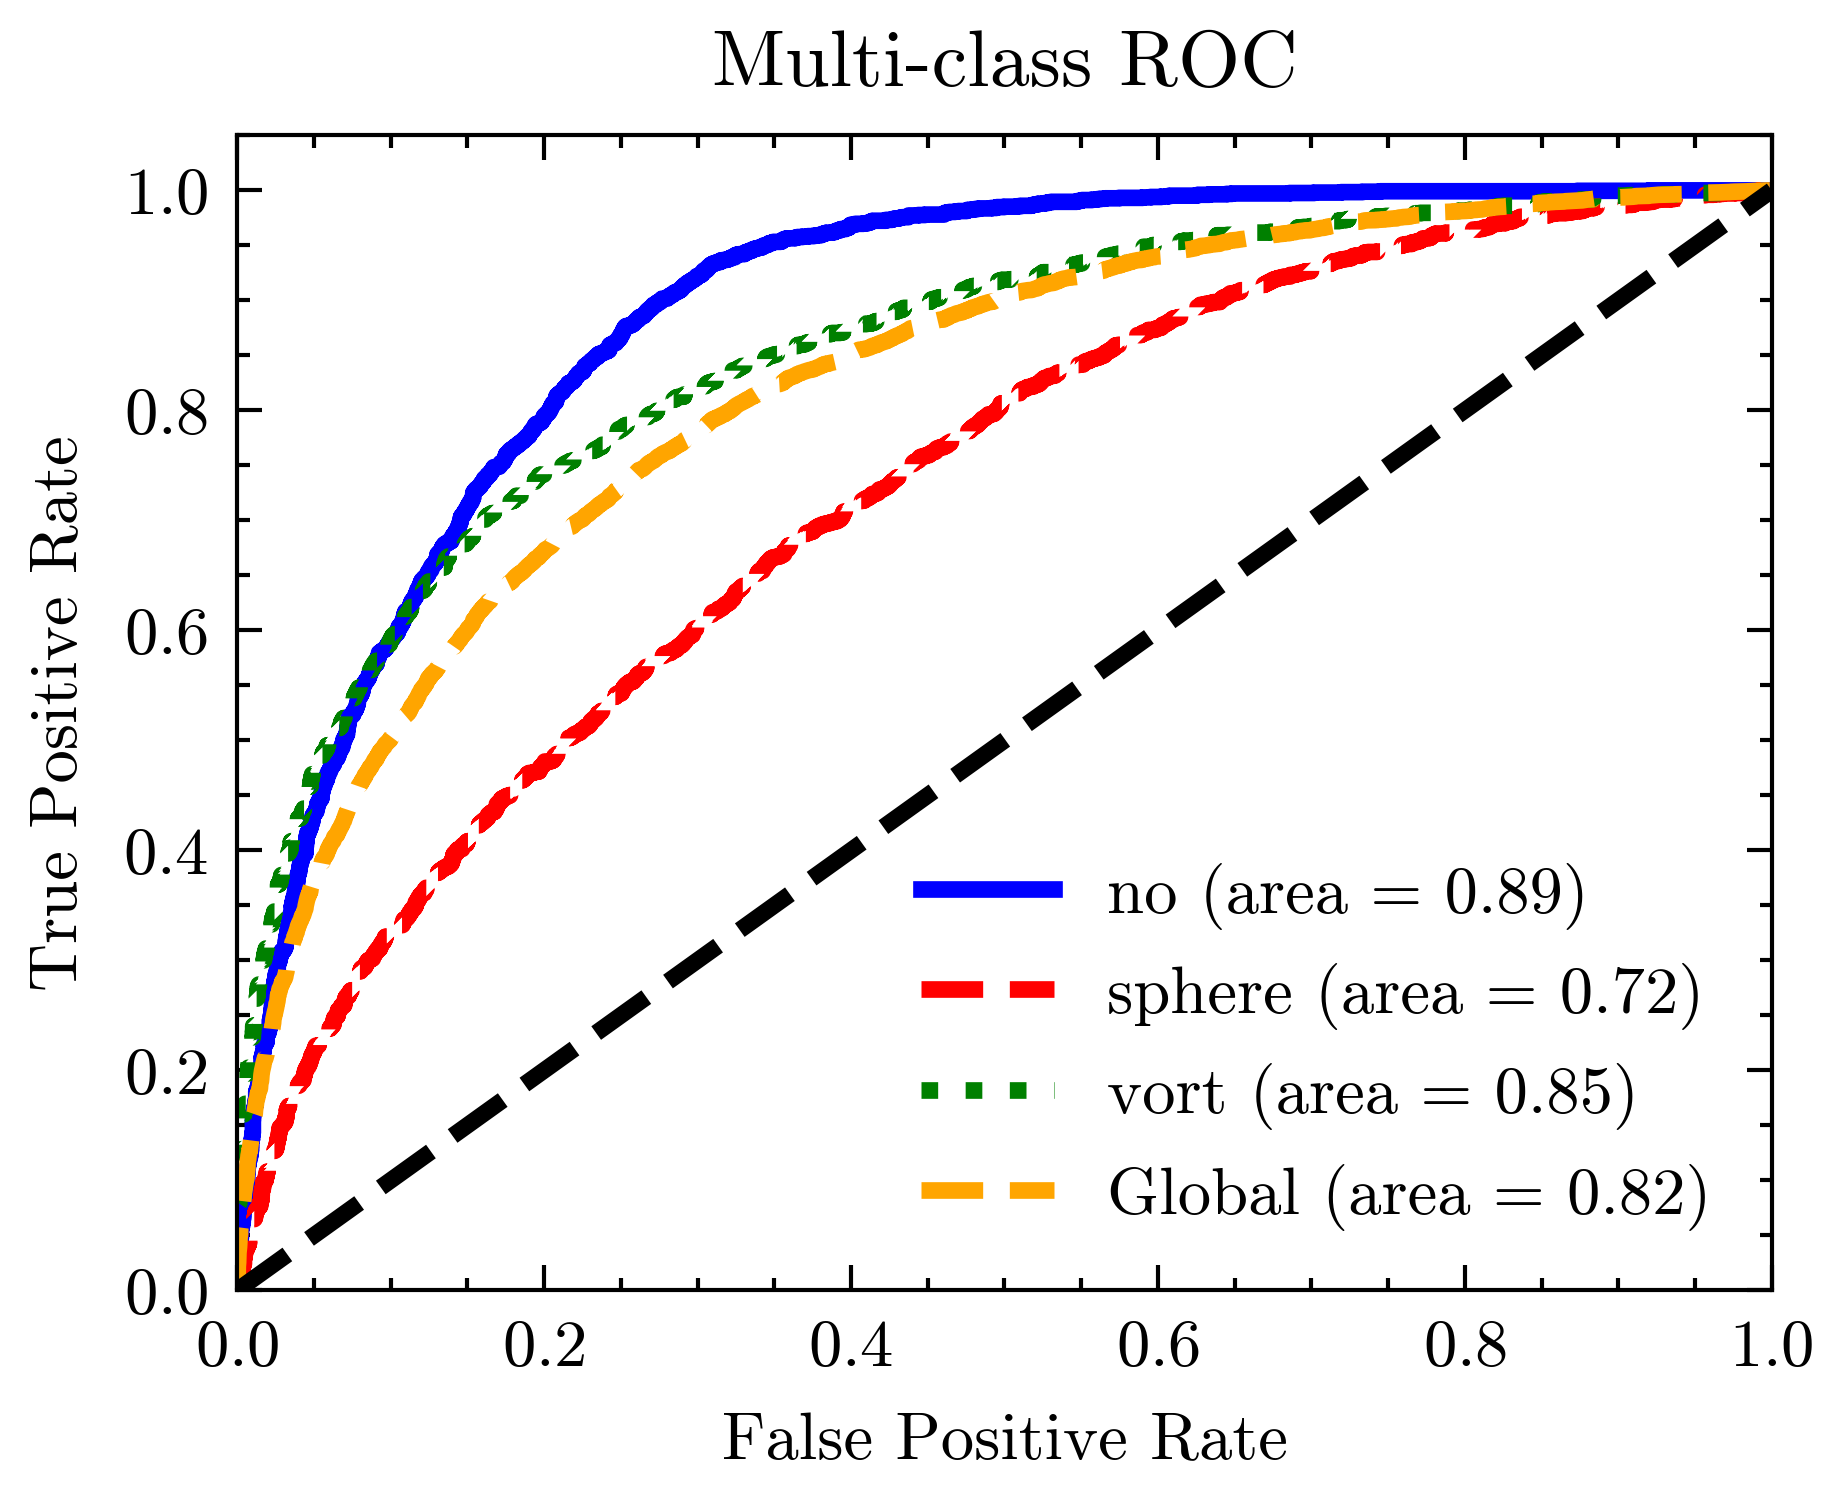

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming y_test are your true class labels and y_score are the predicted probabilities

y_test = []
y_score = []

for item in test_prop:
    y_score += item.detach().cpu().tolist()
for item in test_label:
    y_test += item.detach().cpu().tolist()

y_test = np.array(y_test)
y_score = np.array(y_score)

# Binarize the output classes for one-vs-all computation
n_classes = y_score.shape[1]-1 # Assuming y_score is shape (n_samples, n_classes)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange', 'black', 'purple', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (area = {1:.2f})'
             ''.format(classes[i], roc_auc[i]))
    
plt.plot(fpr["macro"], tpr["macro"],
         label='Global (area = {0:.2f})'.format(roc_auc["macro"]),
         color='orange', linestyle='--', linewidth=2)
plt.legend(fontsize='small')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.savefig("Lensiformer_withK_Multi-class_ROC.png")
plt.show()

# Discussion

#### 1. The current physics-informed model architecture do not overperform the baseline.
#### 2. The transformer architecture is supposed to able to extract the long-range correlation in the image for better classification result, which is not explicitly shown in the baseline study.
#### 3. Some proposals to adopt physics-informed methods: 
##### &nbsp;&nbsp;Proposal A.
&nbsp;&nbsp;&nbsp;&nbsp;Using simulated lensed image and real lense representation function K(x,y) as input, the encoder transformer is trained to generate K'(x,y) and followed with MLP to classify the lense. To optimize the training, the loss function can be constructed with contribution from both cross entropy and difference between K(x,y) and K'(x,y)
##### &nbsp;&nbsp;Proposal B.
&nbsp;&nbsp;&nbsp;&nbsp;Using simulated lensed image *I*_obs(x,y) and actual source image *I*_source(x,y) as input, the encoder transformer is trained to generate K'(x,y) and reverted image *I*_rev(x,y) is created. The following MLP can use K'(x,y) for multilabel classification and loss function can be constructed with both cross entropy and difference  between *I*_rev(x,y) and *I*_source(x,y)
##### &nbsp;&nbsp;Proposal C.
&nbsp;&nbsp;&nbsp;&nbsp;Using simulated lensed image *I*_obs(x,y) as input only, the encoder transformer is trained to generate K'(x,y) and reverted image *I*_rev(x,y) is created. The following MLP can use K'(x,y) for multilabel classification and loss function can be constructed with both cross entropy and the concentration of *I*_rev(x,y). One potential requirement for this approach to work is that dispersion of reverted image with good model-based lense estimation is significant comparing to the intrinsic dispersion of source image. 